# PyDDA ERA5 Example

- Author: [Hamid Ali Syed](https://github.com/syedhamidali)
- E-mail: syed44 [at] purdue [dot] edu


## Install `cdsapi`
First you have to install `cdsapi` using one of the below given options;

<code>mamba install cdsapi</code>

<code>pip install cdsapi</code><br>

<code>conda install -c conda-forge cdsapi</code>

### Also, you need to signup at [CDS-Copernicus](https://cds.climate.copernicus.eu/user/register?destination=%2F%23!%2Fhome)<br>
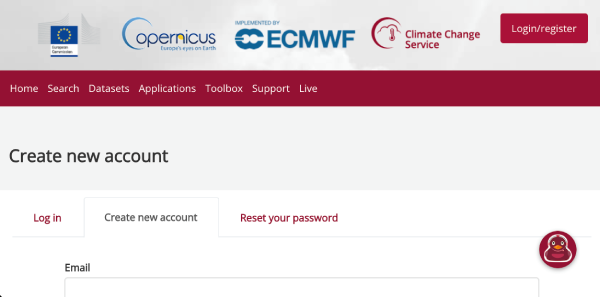

- And, Notedown your `API key` and `UID`: https://cds.climate.copernicus.eu/user/, and paste it in the below given cell, where `88888` is your `UID`, and `aaaa...jklm` is your `API Key`

In [ ]:
!touch ~/.cdsapirc

In [ ]:
%%bash
{ 
  echo 'url: https://cds.climate.copernicus.eu/api/v2'
  echo 'key: 88888:aaaa-1111-bbbb-cccc-defghijklmn'
  echo 'verify: 0'
} > ~/.cdsapirc

## ERA-5 as Intilialization

In [1]:
import pydda
import pyart
import xarray as xr
import os
import warnings
warnings.filterwarnings(action="ignore", category=UserWarning)


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119

Welcome to PyDDA 1.5.0
If you are using PyDDA in your publications, please cite:
Jackson et al. (2020) Journal of Open Research Science
Detecting Jax...
Jax is not installed on your system, unable to use Jax engine.
Detecting TensorFlow...
Unable to load both TensorFlow and tensorflow-probability. TensorFlow engine disabled.
No module named 'tensorflow'


In [2]:
grid1_path = pydda.tests.EXAMPLE_RADAR0
grid2_path = pydda.tests.EXAMPLE_RADAR1
Grid1 = pyart.io.read_grid(grid1_path)
Grid2 = pyart.io.read_grid(grid2_path)

In [3]:
print(Grid1.fields.keys())
print(Grid2.fields.keys())

dict_keys(['reflectivity', 'region_dealias_velocity', 'ROI', 'corrected_velocity', 'AZ', 'EL', 'u', 'v', 'w'])
dict_keys(['Refl', 'corrected_velocity', 'ROI', 'reflectivity', 'AZ', 'EL', 'u', 'v', 'w'])


In [4]:
if any(field_name in Grid1.fields for field_name in ['u', 'v', 'w']):
    # If any of 'u', 'v', or 'w' exists in Grid1.fields, remove them
    fields_to_remove = ['u', 'v', 'w']
    for field_name in fields_to_remove:
        if field_name in Grid1.fields:
            del Grid1.fields[field_name]
print(Grid1.fields.keys())

dict_keys(['reflectivity', 'region_dealias_velocity', 'ROI', 'corrected_velocity', 'AZ', 'EL'])


In [5]:
xg1 = Grid1.to_xarray()
xg2 = Grid2.to_xarray()

In [6]:
print(f"Grid1 Time: {xg1.time.values}")
print(f"Grid2 Time: {xg2.time.values}")
print(f"Grid1 Lon: {Grid1.origin_longitude['data']}")
print(f"Grid2 Lon: {Grid2.origin_longitude['data']}")
print(f"Grid1 Lat: {Grid1.origin_latitude['data']}")
print(f"Grid2 Lat: {Grid2.origin_latitude['data']}")

Grid1 Time: [cftime.DatetimeGregorian(2006, 1, 20, 0, 40, 8, 0, has_year_zero=False)]
Grid2 Time: [cftime.DatetimeGregorian(2006, 1, 20, 0, 40, 3, 0, has_year_zero=False)]
Grid1 Lon: [131.04444444]
Grid2 Lon: [131.04444444]
Grid1 Lat: [-12.24916667]
Grid2 Lat: [-12.24916667]


In [7]:
Grid1 = pydda.initialization.make_initialization_from_era5(
    Grid1, vel_field='corrected_velocity',
    dest_era_file=f'./data/ERA_{str(xg1.time.dt.strftime("%Y%m%d_%H%M%S").values[0])}.nc')

/Users/syed44/miniconda3/envs/radar-env/lib/python3.11/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cds.climate.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
2023-09-22 13:23:54,189 INFO Welcome to the CDS
2023-09-22 13:23:54,190 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
/Users/syed44/miniconda3/envs/radar-env/lib/python3.11/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cds.climate.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
2023-09-22 13:23:54,385 INFO Request is completed
2023-09-22 13:23:54,386 INFO Downloading https://download-0004-clone.co

In [8]:
Grids = [Grid1, Grid2]
for grid in Grids:
    print(grid.fields.keys())

dict_keys(['reflectivity', 'region_dealias_velocity', 'ROI', 'corrected_velocity', 'AZ', 'EL', 'u', 'v', 'w'])
dict_keys(['Refl', 'corrected_velocity', 'ROI', 'reflectivity', 'AZ', 'EL', 'u', 'v', 'w'])


In [9]:
u = Grid1.fields['u']['data']
v = Grid1.fields['v']['data']
w = Grid1.fields['w']['data']

In [20]:
new_grids, _ = pydda.retrieval.get_dd_wind_field(
    Grids,
    u_init=u,
    v_init=v,
    w_init=w,
    Cx=2, Cy=2, Cz=2,
#     filter_window=5,
#     filter_order=3,
    Co=1e-1, Cm=10, frz=3900.0, Cb=0,
    mask_outside_opt=False,
    wind_tol=0.1,
    max_iterations=200,
    engine="scipy",
    refl_field='reflectivity',
    vel_name='corrected_velocity')

/Users/syed44/miniconda3/envs/radar-env/lib/python3.11/site-packages/pydda-1.5.0-py3.11.egg/pydda/retrieval/angles.py:24: RuntimeWarning: invalid value encountered in arccos
  elev = np.arccos((Re**2 + slantrsq - rh**2) / (2 * Re * slantr))


Calculating weights for radars 0 and 1
Calculating weights for radars 1 and 0
Calculating weights for models...
Starting solver 
rmsVR = 6.827303971100175
Total points: 81194
The max of w_init is 0.42438711278262087
Nfeval | Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
      0|9259.8431|   0.0384|   0.0000|   0.0000|   0.0000|   0.0000|   0.0000|   1.1044
The gradient of the cost functions is 0.10854386830317178
Nfeval | Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
     10|   1.5693|   2.0956|   0.0000|   0.0000|   0.0000|   0.0000|   0.0000|  13.9551
Max change in w: 13.377
The gradient of the cost functions is 0.05448951741426876
Nfeval | Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
     20|   1.8431|   1.8132|   0.0000|   0.0000|   0.0000|   0.0000|   0.0000|  13.5575
The gradient of the cost functions is 0.02811968162086173
Nfeval | Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jm

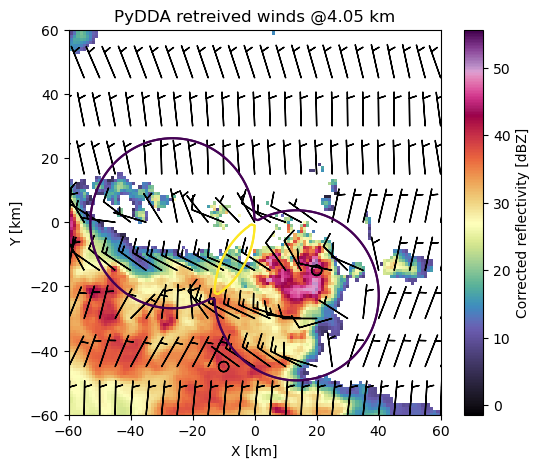

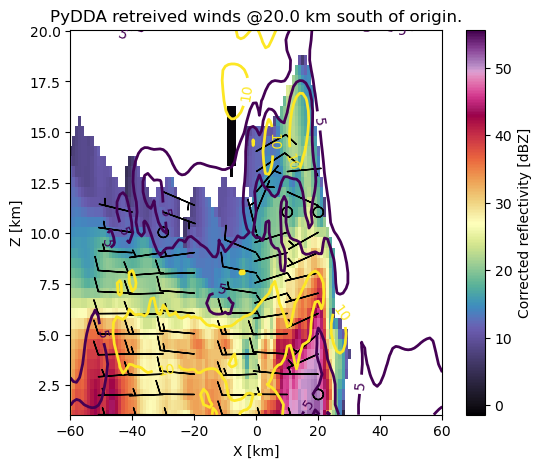

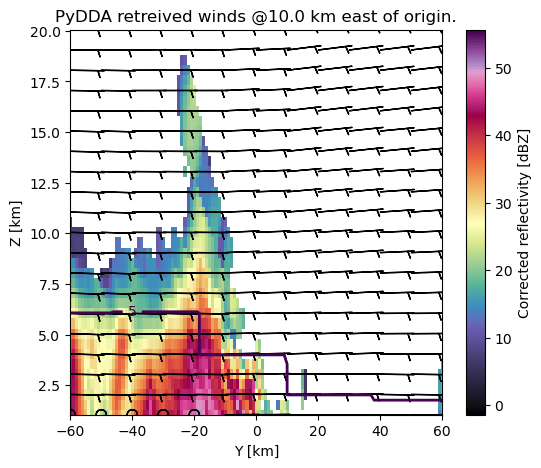

In [24]:
import matplotlib.pyplot as plt
# Plot a horizontal cross section
plt.figure(figsize=(6, 5))
pydda.vis.plot_horiz_xsection_barbs(
    new_grids,
    background_field="reflectivity",
    level=6,
    w_vel_contours=[5, 10, 15],
    barb_spacing_x_km=5.0,
    barb_spacing_y_km=15.0,
    colorbar_flag=True, cmap='pyart_ChaseSpectral')
plt.show()
# Plot a vertical X-Z cross section
plt.figure(figsize=(6, 5))
pydda.vis.plot_xz_xsection_barbs(
    new_grids,
    background_field="reflectivity",
    level=40,
    w_vel_contours=[5, 10, 15],
    barb_spacing_x_km=10.0,
    barb_spacing_z_km=2.0,
    colorbar_flag=True, cmap='pyart_ChaseSpectral',
    wind_vel_contours=[5, 10])
plt.show()

# Plot a vertical Y-Z cross section
plt.figure(figsize=(6, 5))
pydda.vis.plot_yz_xsection_barbs(
    Grids,
    background_field="reflectivity",
    level=70,
    barb_spacing_y_km=10.0,
    barb_spacing_z_km=2.0,
    colorbar_flag=True, cmap='pyart_ChaseSpectral', wind_vel_contours=[5, 10])
plt.show()

## ERA-5 as Constraint

In [10]:
Grid1 = pydda.constraints.make_constraint_from_era5(Grid1,
                                                    vel_field='corrected_velocity',
                                                    file_name="./data/ERA_20060120_004008.nc")
Grid1 = pydda.initialization.make_constant_wind_field(Grid1, (0.0, 0.0, 0.0), vel_field='corrected_velocity')

In [15]:
# Grid1.fields['U'] = Grid1.fields.pop('u')
# Grid1.fields['V'] = Grid1.fields.pop('v')
# Grid1.fields['W'] = Grid1.fields.pop('w')

In [13]:
print(Grid1.fields.keys())

dict_keys(['reflectivity', 'region_dealias_velocity', 'ROI', 'corrected_velocity', 'AZ', 'EL', 'u', 'v', 'w', 'U_era5', 'V_era5', 'W_era5'])


In [19]:
new_grids, _ = pydda.retrieval.get_dd_wind_field(
    [Grid1, Grid2],
    Cmod=0,
    Cx=2, Cy=2, Cz=2,
    Co=1e-1, Cm=10, frz=3900.0, Cb=0,
    wind_tol=0.1,
    max_iterations=100,
    mask_outside_opt=True,
    engine="scipy",
    refl_field='reflectivity',
    vel_name='corrected_velocity',
    model_fields=["era5"],)

/Users/syed44/miniconda3/envs/radar-env/lib/python3.11/site-packages/pydda-1.5.0-py3.11.egg/pydda/retrieval/angles.py:24: RuntimeWarning: invalid value encountered in arccos
  elev = np.arccos((Re**2 + slantrsq - rh**2) / (2 * Re * slantr))


Calculating weights for radars 0 and 1
Calculating weights for radars 1 and 0
Calculating weights for models...
Starting solver 
rmsVR = 6.827303971100175
Total points: 81194
The max of w_init is 0.0
Nfeval | Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
      0|8354.6051|   0.0000|   0.0000|   0.0000|   0.0000|   0.0000|   0.0000|   0.0000
The gradient of the cost functions is 0.0858486174984685
Nfeval | Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
     10|   1.1601|   1.6043|   0.0000|   0.0000|   0.0000|   0.0000|   0.0000|  10.9579
Max change in w: 10.891
The gradient of the cost functions is 0.08894957720221888
Nfeval | Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
     20|   0.8974|   1.4081|   0.0000|   0.0000|   0.0000|   0.0000|   0.0000|  10.6016
The gradient of the cost functions is 0.03423140188837688
Nfeval | Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  |

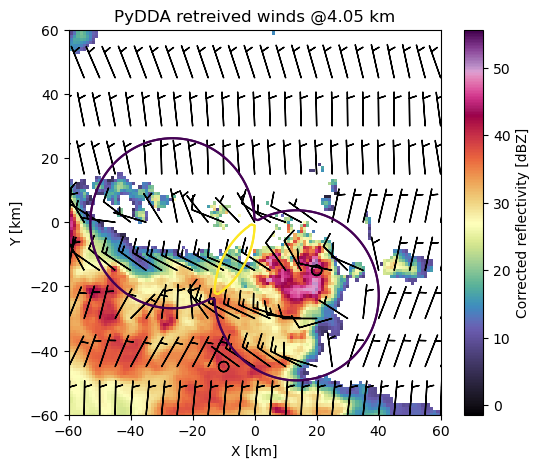

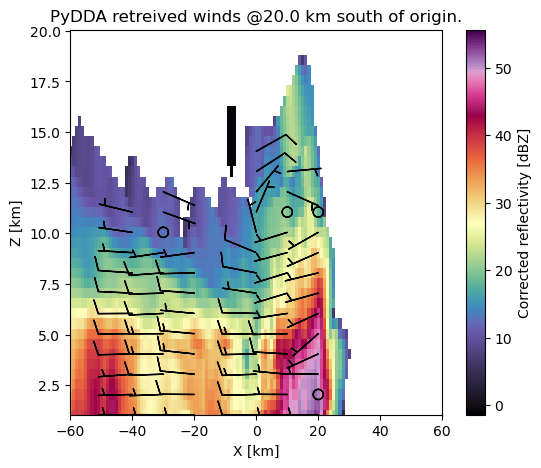

<Axes: title={'center': 'PyDDA retreived winds @10.0 km east of origin.'}, xlabel='Y [km]', ylabel='Z [km]'>

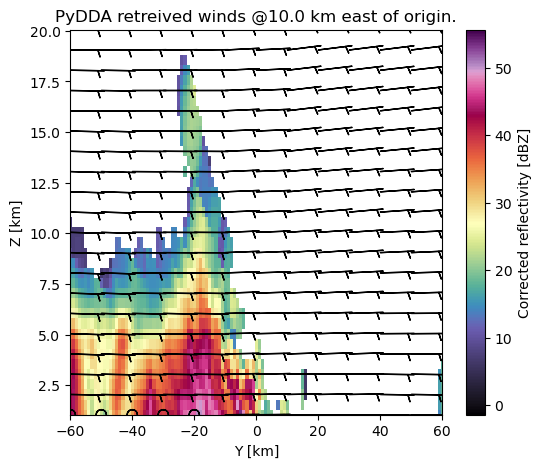

In [25]:
import matplotlib.pyplot as plt
# Plot a horizontal cross section
plt.figure(figsize=(6, 5))
pydda.vis.plot_horiz_xsection_barbs(
    new_grids,
    background_field="reflectivity",
    level=6,
    w_vel_contours=[5, 10, 15],
    barb_spacing_x_km=5.0,
    barb_spacing_y_km=15.0,
    cmap='pyart_ChaseSpectral')

plt.show()
# Plot a vertical X-Z cross section
plt.figure(figsize=(6, 5))
pydda.vis.plot_xz_xsection_barbs(
    new_grids,
    background_field="reflectivity",
    level=40,
    w_vel_contours=[5, 10, 15],
    barb_spacing_x_km=10.0,
    barb_spacing_z_km=2.0,
    cmap='pyart_ChaseSpectral')
plt.show()

# Plot a vertical Y-Z cross section
plt.figure(figsize=(6, 5))
pydda.vis.plot_yz_xsection_barbs(
    Grids,
    background_field="reflectivity",
    level=70,
    barb_spacing_y_km=10.0,
    barb_spacing_z_km=2.0,
    cmap='pyart_ChaseSpectral')

In [33]:
xg = new_grids[0].to_xarray()

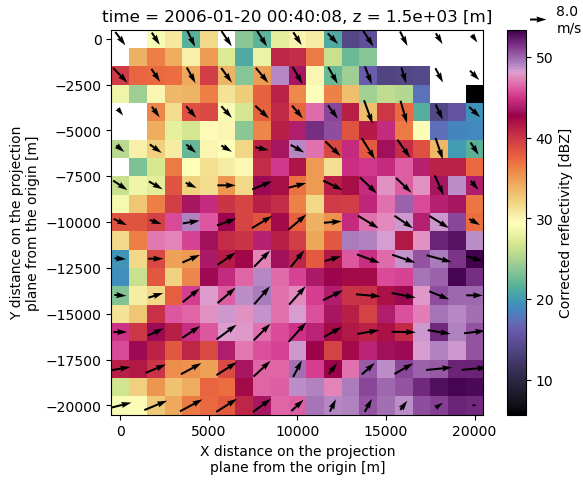

In [39]:
xg = new_grids[0].to_xarray().isel(time=0, z=1).sel(x=slice(0, 20e3), y=slice(-20e3, 0))
fig, ax = plt.subplots(figsize=[6, 5], dpi=100)
xg['reflectivity'].plot(cmap='pyart_ChaseSpectral', ax=ax)
stride = 2  # Adjust the stride value to control the density of arrows
xg_downsampled = xg.isel(x=slice(None, None, stride), y=slice(None, None, stride))
xg_downsampled.plot.quiver(x='x', y='y', u='u', v='v', ax=ax,  pivot='mid')

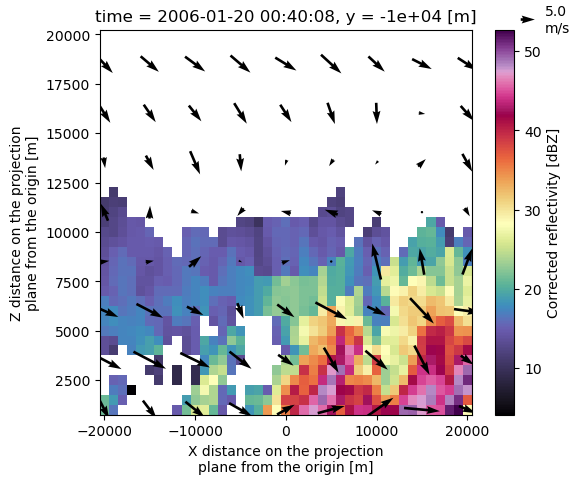

In [44]:
xg = new_grids[0].to_xarray().isel(time=0).sel(x=slice(-20e3, 20e3), y=-10e3)
fig, ax = plt.subplots(figsize=[6, 5], dpi=100)
xg['reflectivity'].plot(cmap='pyart_ChaseSpectral', ax=ax)
stride = 5  # Adjust the stride value to control the density of arrows
xg_downsampled = xg.isel(x=slice(None, None, stride), z=slice(None, None, stride))
xg_downsampled.plot.quiver(x='x', y='z', u='u', v='v', ax=ax,  pivot='mid')